In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

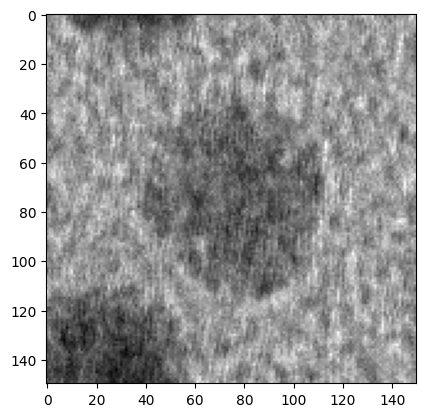

In [71]:
img_path = r"C:\Users\penda\Documents\Study Materials\Image Processing\PROJECT\PROJECT DATASET\Images\TEM67\TEM67_crop24.jpg"
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")

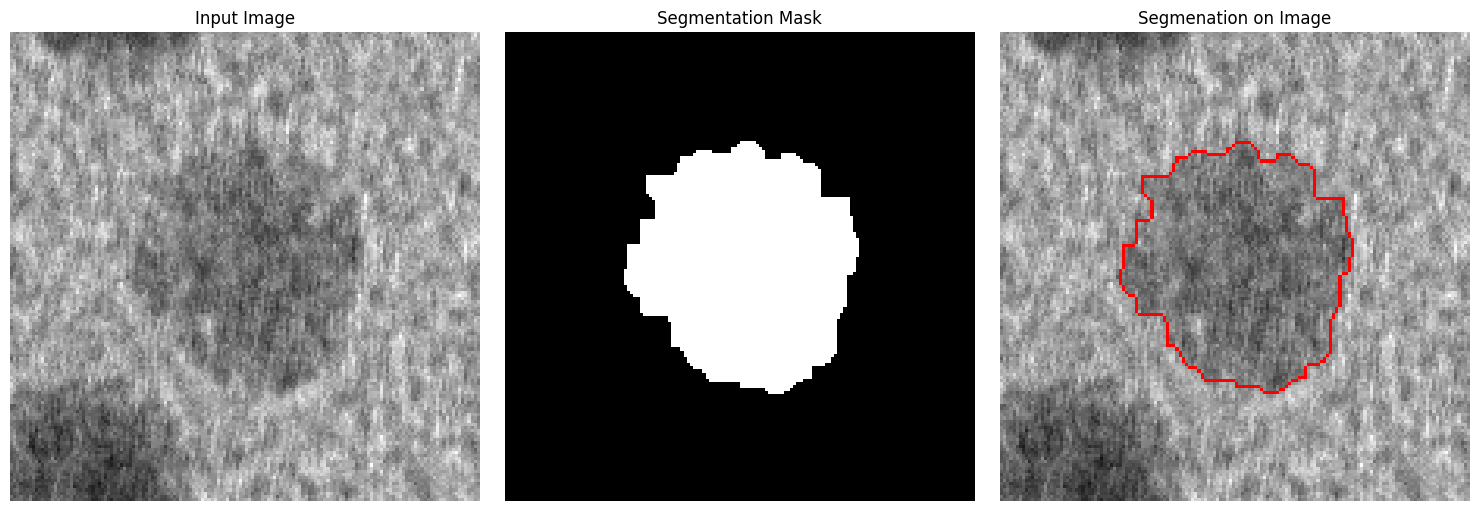

In [72]:
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding using the mean value
_, thresh = cv2.threshold(blurred, np.mean(blurred), 255, cv2.THRESH_BINARY_INV)

# Apply Morphological Opening to remove small patches
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours in the processed image
contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the center of the image
image_center = (image.shape[1] // 2, image.shape[0] // 2)

# Function to calculate the distance from the contour's centroid to the image center
def contour_distance_to_center(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        distance = np.sqrt((cX - image_center[0]) ** 2 + (cY - image_center[1]) ** 2)
        return distance
    return float('inf')

# Sort contours first by distance to center, then by area
contours_sorted = sorted(contours, key=lambda contour: (contour_distance_to_center(contour), -cv2.contourArea(contour)))

# Select the largest contour closest to the center
largest_contour_closest_to_center = contours_sorted[0] if contours_sorted else None

# Create a blank mask and draw the largest contour
mask = np.zeros_like(gray, dtype="uint8")
if largest_contour_closest_to_center is not None:
    cv2.drawContours(mask, [largest_contour_closest_to_center], -1, (255), thickness=cv2.FILLED)

# Fill small spaces in the mask
filled_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Draw contours of the refined segmentation mask on the original image in red
segmented_image_with_red_line = image.copy()
refined_contours, _ = cv2.findContours(filled_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(segmented_image_with_red_line, refined_contours, -1, (0, 0, 255), thickness=1)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Segmentation Mask")
plt.imshow(filled_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Segmenation on Image")
plt.imshow(cv2.cvtColor(segmented_image_with_red_line, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()